In [3]:
# Import all required libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import zipfile
import io
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

print("TensorFlow version:", tf.__version__)
print("All libraries imported successfully!")


/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


TensorFlow version: 2.20.0
All libraries imported successfully!


In [4]:
# Download the Jena Climate dataset
print("Downloading Jena Climate Dataset...")
url = 'https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip'
response = requests.get(url)
zf = zipfile.ZipFile(io.BytesIO(response.content))
df = pd.read_csv(zf.open(zf.namelist()[0]))

print(f"✅ Dataset downloaded successfully!")
print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())


✅ Dataset downloaded successfully!
Dataset shape: (420551, 15)

First few rows:
             Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
0  01.01.2009 00:10:00    996.52     -8.02    265.40        -8.90    93.3   
1  01.01.2009 00:20:00    996.57     -8.41    265.01        -9.28    93.4   
2  01.01.2009 00:30:00    996.53     -8.51    264.91        -9.31    93.9   
3  01.01.2009 00:40:00    996.51     -8.31    265.12        -9.07    94.2   
4  01.01.2009 00:50:00    996.51     -8.27    265.15        -9.04    94.1   

   VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  \
0          3.33          3.11          0.22       1.94             3.12   
1          3.23          3.02          0.21       1.89             3.03   
2          3.21          3.01          0.20       1.88             3.02   
3          3.26          3.07          0.19       1.92             3.08   
4          3.27          3.08          0.19       1.92             3.09   

   rho

In [5]:
# Check dataset information
print("\n📊 Dataset Information:")
print(df.info())

print("\n📈 Statistical Summary:")
print(df.describe())

print("\n❓ Missing Values:")
print(df.isnull().sum())

print("\n📅 Date Range:")
df['Date Time'] = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S')
print(f"From: {df['Date Time'].min()}")
print(f"To: {df['Date Time'].max()}")



📊 Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420551 entries, 0 to 420550
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Date Time        420551 non-null  object 
 1   p (mbar)         420551 non-null  float64
 2   T (degC)         420551 non-null  float64
 3   Tpot (K)         420551 non-null  float64
 4   Tdew (degC)      420551 non-null  float64
 5   rh (%)           420551 non-null  float64
 6   VPmax (mbar)     420551 non-null  float64
 7   VPact (mbar)     420551 non-null  float64
 8   VPdef (mbar)     420551 non-null  float64
 9   sh (g/kg)        420551 non-null  float64
 10  H2OC (mmol/mol)  420551 non-null  float64
 11  rho (g/m**3)     420551 non-null  float64
 12  wv (m/s)         420551 non-null  float64
 13  max. wv (m/s)    420551 non-null  float64
 14  wd (deg)         420551 non-null  float64
dtypes: float64(14), object(1)
memory usage: 48.1+ MB
None

📈 Stat

In [6]:
# Resample to hourly data
print("Preprocessing data...")
df_hourly = df.set_index('Date Time').resample('1H').mean()
df_hourly = df_hourly.dropna()

# Select important features for modeling
features = [
    'T (degC)',        # Temperature (our target)
    'p (mbar)',        # Pressure
    'rh (%)',          # Humidity
    'VPmax (mbar)',    # Max vapor pressure
    'VPact (mbar)',    # Actual vapor pressure
    'sh (g/kg)',       # Specific humidity
    'rho (g/m**3)',    # Air density
    'wv (m/s)',        # Wind speed
    'max. wv (m/s)'    # Max wind speed
]

df_model = df_hourly[features].copy()
df_model = df_model.fillna(method='ffill').fillna(method='bfill')

print(f"✅ Preprocessed data shape: {df_model.shape}")
print(f"Features used: {len(features)}")
print(df_model.head())


Preprocessing data...
✅ Preprocessed data shape: (70041, 9)
Features used: 9
                     T (degC)    p (mbar)     rh (%)  VPmax (mbar)  \
Date Time                                                            
2009-01-01 00:00:00 -8.304000  996.528000  93.780000      3.260000   
2009-01-01 01:00:00 -8.065000  996.525000  93.933333      3.323333   
2009-01-01 02:00:00 -8.763333  996.745000  93.533333      3.145000   
2009-01-01 03:00:00 -8.896667  996.986667  93.200000      3.111667   
2009-01-01 04:00:00 -9.348333  997.158333  92.383333      3.001667   

                     VPact (mbar)  sh (g/kg)  rho (g/m**3)  wv (m/s)  \
Date Time                                                              
2009-01-01 00:00:00      3.058000   1.910000   1309.196000  0.520000   
2009-01-01 01:00:00      3.121667   1.951667   1307.981667  0.316667   
2009-01-01 02:00:00      2.940000   1.836667   1311.816667  0.248333   
2009-01-01 03:00:00      2.898333   1.811667   1312.813333  0.176667   


/tmp/ipython-input-2355972272.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df.set_index('Date Time').resample('1H').mean()
/tmp/ipython-input-2355972272.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_model = df_model.fillna(method='ffill').fillna(method='bfill')


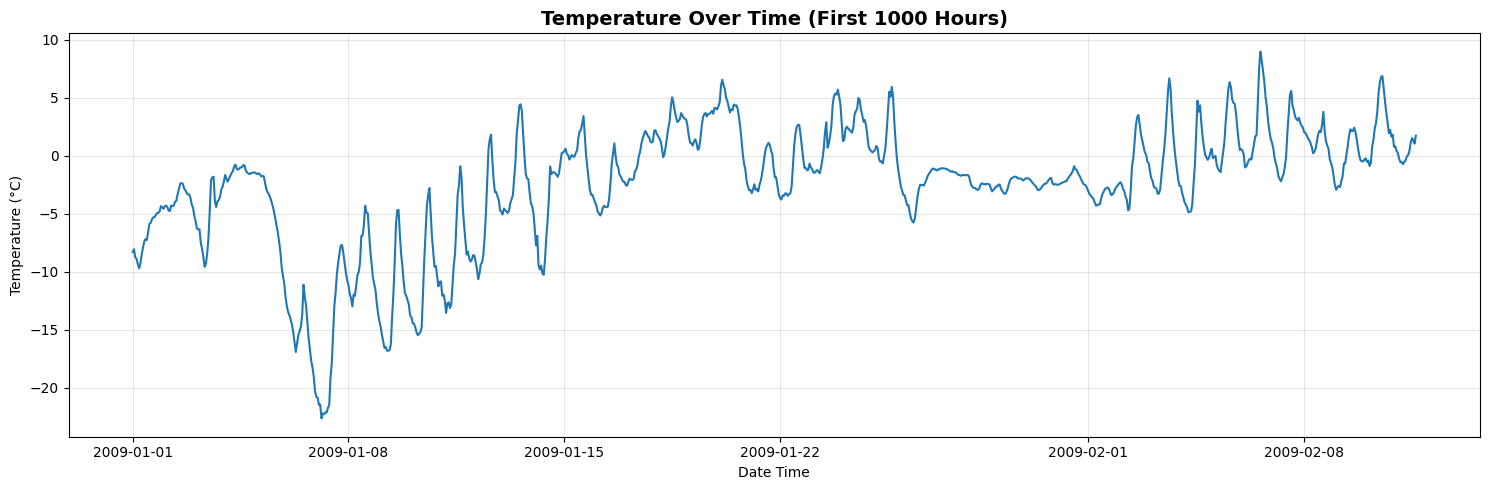

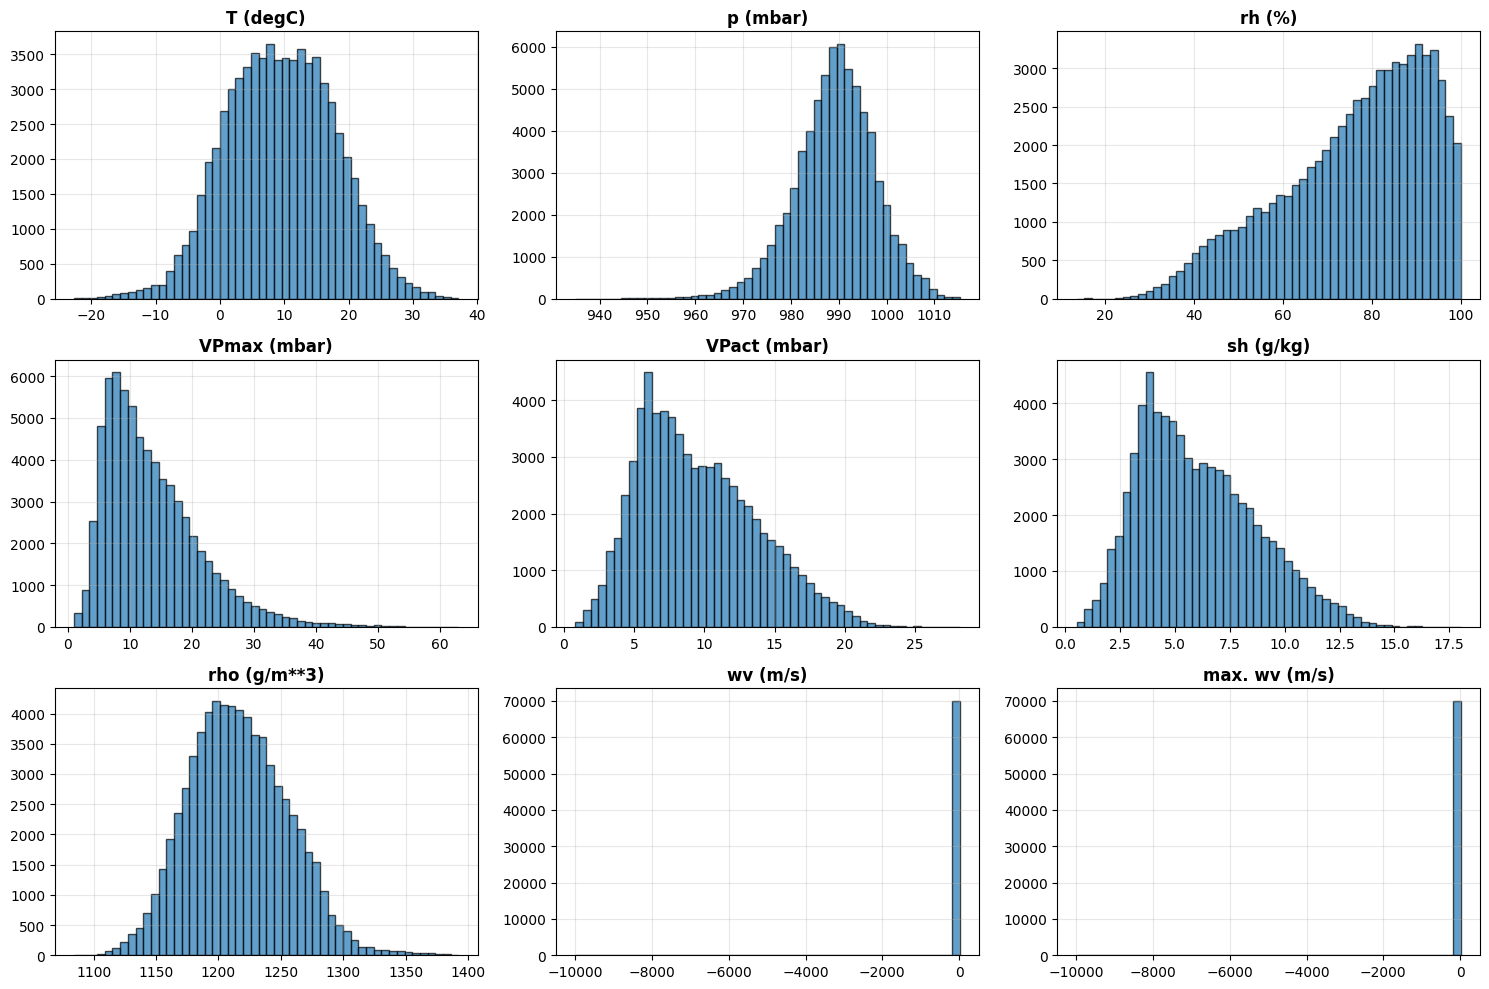

In [7]:
# Plot temperature over time
plt.figure(figsize=(15, 5))
plt.plot(df_model.index[:1000], df_model['T (degC)'][:1000])
plt.title('Temperature Over Time (First 1000 Hours)', fontsize=14, fontweight='bold')
plt.xlabel('Date Time')
plt.ylabel('Temperature (°C)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot feature distributions
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axes = axes.flatten()
for i, feature in enumerate(features):
    axes[i].hist(df_model[feature], bins=50, edgecolor='black', alpha=0.7)
    axes[i].set_title(feature, fontweight='bold')
    axes[i].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [8]:
def create_sequences(data, sequence_length, forecast_horizon):
    """
    Create input sequences and corresponding labels for time series forecasting

    Args:
        data: numpy array of shape (n_samples, n_features)
        sequence_length: number of past time steps to use as input
        forecast_horizon: number of time steps ahead to predict

    Returns:
        X: input sequences of shape (n_sequences, sequence_length, n_features)
        y: target values of shape (n_sequences,)
    """
    X, y = [], []

    for i in range(len(data) - sequence_length - forecast_horizon + 1):
        # Input sequence (past observations)
        X.append(data[i:(i + sequence_length)])
        # Target (future temperature)
        y.append(data[i + sequence_length + forecast_horizon - 1, 0])  # T (degC) is index 0

    return np.array(X), np.array(y)

# Parameters
SEQUENCE_LENGTH = 120  # 5 days of hourly data
FORECAST_HORIZON = 12  # Predict 12 hours ahead

print(f"⚙️ Configuration:")
print(f"  - Sequence Length: {SEQUENCE_LENGTH} hours (5 days)")
print(f"  - Forecast Horizon: {FORECAST_HORIZON} hours ahead")


⚙️ Configuration:
  - Sequence Length: 120 hours (5 days)
  - Forecast Horizon: 12 hours ahead


In [9]:
# Prepare data array
data_array = df_model.values.astype(np.float32)
print(f"Original data array shape: {data_array.shape}")

# Create sequences
print("\nCreating sequences...")
X, y = create_sequences(data_array, SEQUENCE_LENGTH, FORECAST_HORIZON)

print(f"✅ Sequences created successfully!")
print(f"  - Input sequences (X) shape: {X.shape}")
print(f"  - Target values (y) shape: {y.shape}")
print(f"  - Total sequences: {len(X)}")


Original data array shape: (70041, 9)

Creating sequences...
✅ Sequences created successfully!
  - Input sequences (X) shape: (69910, 120, 9)
  - Target values (y) shape: (69910,)
  - Total sequences: 69910


In [10]:
# Chronological split to avoid data leakage
train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))

X_train = X[:train_size]
y_train = y[:train_size]
X_val = X[train_size:train_size + val_size]
y_val = y[train_size:train_size + val_size]
X_test = X[train_size + val_size:]
y_test = y[train_size + val_size:]

print(f"📊 Data Split:")
print(f"  - Training samples: {X_train.shape[0]} ({train_size/len(X)*100:.1f}%)")
print(f"  - Validation samples: {X_val.shape[0]} ({val_size/len(X)*100:.1f}%)")
print(f"  - Test samples: {X_test.shape[0]} ({(len(X)-train_size-val_size)/len(X)*100:.1f}%)")


📊 Data Split:
  - Training samples: 48937 (70.0%)
  - Validation samples: 10486 (15.0%)
  - Test samples: 10487 (15.0%)


In [11]:
# Normalize features using StandardScaler
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Fit scalers on training data only
X_train_scaled = scaler_X.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()

# Transform validation and test sets
X_val_scaled = scaler_X.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).flatten()
X_test_scaled = scaler_X.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

print(f"✅ Data normalized successfully!")
print(f"  - X_train_scaled shape: {X_train_scaled.shape}")
print(f"  - y_train_scaled shape: {y_train_scaled.shape}")


✅ Data normalized successfully!
  - X_train_scaled shape: (48937, 120, 9)
  - y_train_scaled shape: (48937,)


In [12]:
def build_bilstm_model(sequence_length, n_features, lstm_units=32):
    """Build BiLSTM model for temperature forecasting"""

    model = Sequential([
        # Input layer
        tf.keras.layers.Input(shape=(sequence_length, n_features)),

        # Bidirectional LSTM layer
        Bidirectional(LSTM(lstm_units, return_sequences=False)),

        # Dropout for regularization
        Dropout(0.2),

        # Dense layers
        Dense(16, activation='relu'),
        Dropout(0.1),
        Dense(1)  # Output layer
    ])

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )

    return model

# Build the model
n_features = X_train_scaled.shape[2]
model = build_bilstm_model(SEQUENCE_LENGTH, n_features)

print("🏗️ Model Architecture:")
model.summary()


🏗️ Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 64)             │        10,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,809 (46.13 KB)

 Trainable params: 11,809 (46.13 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Training callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
]

# Training parameters
BATCH_SIZE = 256
EPOCHS = 50  # Can be more, early stopping will handle it

print(f"⚙️ Training Configuration:")
print(f"  - Batch Size: {BATCH_SIZE}")
print(f"  - Max Epochs: {EPOCHS}")
print(f"  - Early Stopping Patience: 10 epochs")
print(f"  - Learning Rate Reduction: On")


⚙️ Training Configuration:
  - Batch Size: 256
  - Max Epochs: 50
  - Early Stopping Patience: 10 epochs
  - Learning Rate Reduction: On


In [14]:
print("\n🚀 Starting Training...")
print("="*60)

history = model.fit(
    X_train_scaled, y_train_scaled,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val_scaled, y_val_scaled),
    callbacks=callbacks,
    verbose=1
)

print("\n✅ Training completed!")



🚀 Starting Training...
Epoch 1/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - loss: 0.3476 - mae: 0.4492 - val_loss: 0.1273 - val_mae: 0.2761 - learning_rate: 0.0010
Epoch 2/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - loss: 0.1498 - mae: 0.3027 - val_loss: 0.1115 - val_mae: 0.2597 - learning_rate: 0.0010
Epoch 3/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - loss: 0.1285 - mae: 0.2794 - val_loss: 0.1057 - val_mae: 0.2528 - learning_rate: 0.0010
Epoch 4/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 0.1220 - mae: 0.2710 - val_loss: 0.1044 - val_mae: 0.2511 - learning_rate: 0.0010
Epoch 5/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 0.1158 - mae: 0.2648 - val_loss: 0.1007 - val_mae: 0.2470 - learning_rate: 0.0010
Epoch 6/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 0.1133 - mae: 0.2624 - val_loss: 0.0995 - val_mae: 0.2452 - learning_rate: 0.0010
Epoch 7/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 0.1091 - mae: 0.2570 - val_loss: 0.1006 - val_mae:

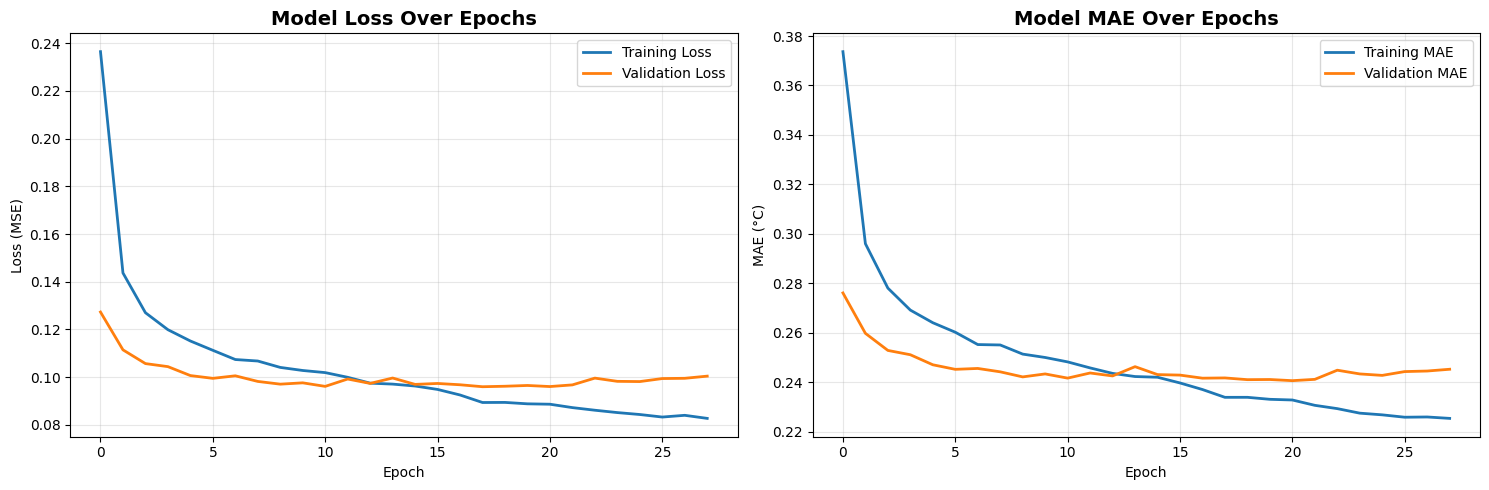

📊 Training Summary:
  - Final Training Loss: 0.0827
  - Final Validation Loss: 0.1004
  - Final Training MAE: 0.2253°C
  - Final Validation MAE: 0.2452°C


In [15]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(history.history['loss'], label='Training Loss', linewidth=2)
ax1.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
ax1.set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
ax1.set_ylabel('Loss (MSE)')
ax1.set_xlabel('Epoch')
ax1.legend()
ax1.grid(True, alpha=0.3)

# MAE plot
ax2.plot(history.history['mae'], label='Training MAE', linewidth=2)
ax2.plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
ax2.set_title('Model MAE Over Epochs', fontsize=14, fontweight='bold')
ax2.set_ylabel('MAE (°C)')
ax2.set_xlabel('Epoch')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"📊 Training Summary:")
print(f"  - Final Training Loss: {history.history['loss'][-1]:.4f}")
print(f"  - Final Validation Loss: {history.history['val_loss'][-1]:.4f}")
print(f"  - Final Training MAE: {history.history['mae'][-1]:.4f}°C")
print(f"  - Final Validation MAE: {history.history['val_mae'][-1]:.4f}°C")


In [16]:
print("\n🧪 Testing the Model...")

# Make predictions
y_pred_scaled = model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_true = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()

print(f"✅ Predictions completed!")
print(f"  - Test samples predicted: {len(y_pred)}")



🧪 Testing the Model...
328/328 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
✅ Predictions completed!
  - Test samples predicted: 10487


In [17]:
# Calculate metrics
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f"\n📈 Model Performance on Test Set:")
print("="*60)
print(f"  - Mean Absolute Error (MAE): {mae:.4f}°C")
print(f"  - Root Mean Squared Error (RMSE): {rmse:.4f}°C")
print(f"  - R² Score: {r2:.4f}")
print("="*60)



📈 Model Performance on Test Set:
  - Mean Absolute Error (MAE): 2.0812°C
  - Root Mean Squared Error (RMSE): 2.5896°C
  - R² Score: 0.8893


In [18]:
# Create a detailed output table
output_df = pd.DataFrame({
    'Sample': range(1, 51),  # First 50 samples
    'Actual Temperature (°C)': y_true[:50],
    'Predicted Temperature (°C)': y_pred[:50],
    'Error (°C)': y_true[:50] - y_pred[:50],
    'Absolute Error (°C)': np.abs(y_true[:50] - y_pred[:50])
})

print("\n📋 Sample Predictions (First 50 Test Samples):")
print("="*80)
print(output_df.to_string(index=False))
print("="*80)



📋 Sample Predictions (First 50 Test Samples):
 Sample  Actual Temperature (°C)  Predicted Temperature (°C)  Error (°C)  Absolute Error (°C)
      1                 4.940000                    4.355684    0.584316             0.584316
      2                 4.763333                    4.252965    0.510368             0.510368
      3                 4.333333                    3.935446    0.397888             0.397888
      4                 4.135000                    3.540270    0.594730             0.594730
      5                 3.766666                    3.327856    0.438811             0.438811
      6                 3.473333                    3.101963    0.371371             0.371371
      7                 3.670000                    3.102395    0.567605             0.567605
      8                 3.901667                    3.265335    0.636332             0.636332
      9                 4.403333                    3.646017    0.757317             0.757317
     10      

In [19]:
# Save all test predictions to CSV
full_output_df = pd.DataFrame({
    'Sample': range(1, len(y_true)+1),
    'Actual_Temperature_C': y_true,
    'Predicted_Temperature_C': y_pred,
    'Error_C': y_true - y_pred,
    'Absolute_Error_C': np.abs(y_true - y_pred)
})

full_output_df.to_csv('bilstm_test_predictions.csv', index=False)
print(f"\n💾 Full test predictions saved to: bilstm_test_predictions.csv")



💾 Full test predictions saved to: bilstm_test_predictions.csv


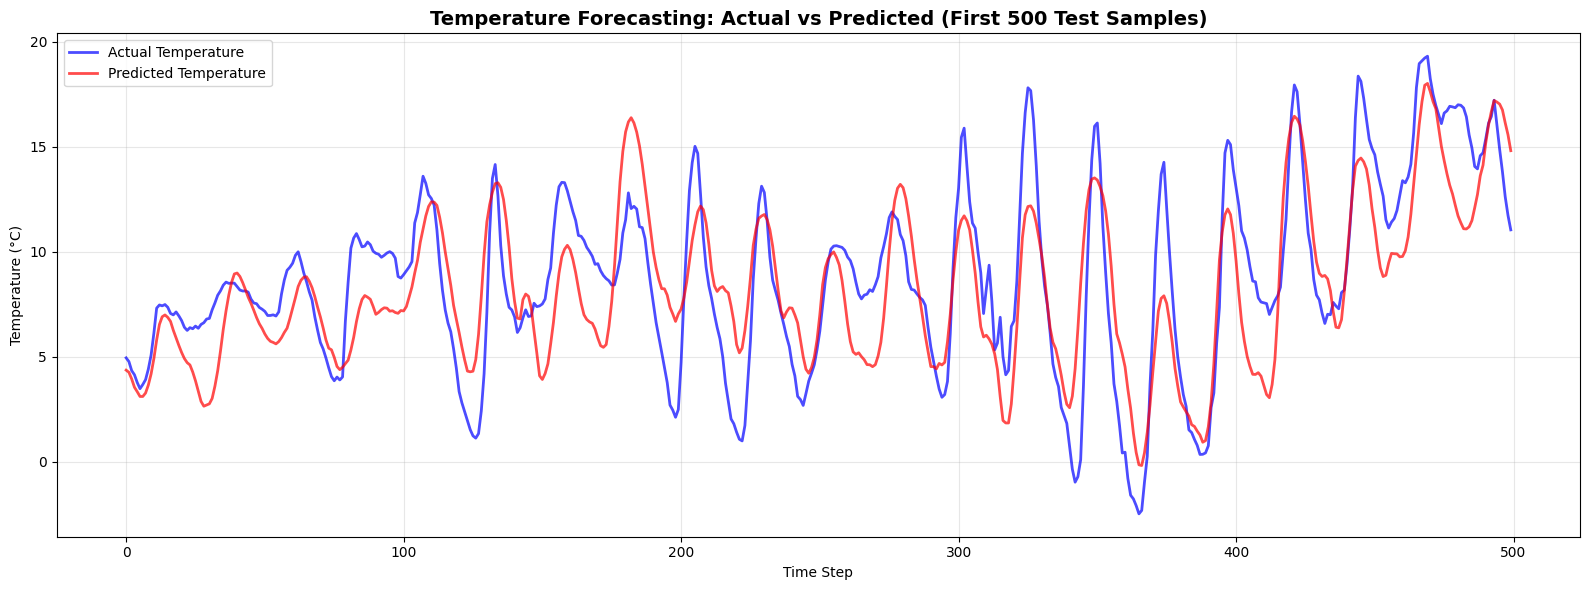

In [20]:
# Plot predictions vs actual (first 500 samples for clarity)
n_samples = 500
plt.figure(figsize=(16, 6))
time_steps = np.arange(n_samples)

plt.plot(time_steps, y_true[:n_samples], 'b-', label='Actual Temperature', alpha=0.7, linewidth=2)
plt.plot(time_steps, y_pred[:n_samples], 'r-', label='Predicted Temperature', alpha=0.7, linewidth=2)

plt.title('Temperature Forecasting: Actual vs Predicted (First 500 Test Samples)',
          fontsize=14, fontweight='bold')
plt.xlabel('Time Step')
plt.ylabel('Temperature (°C)')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


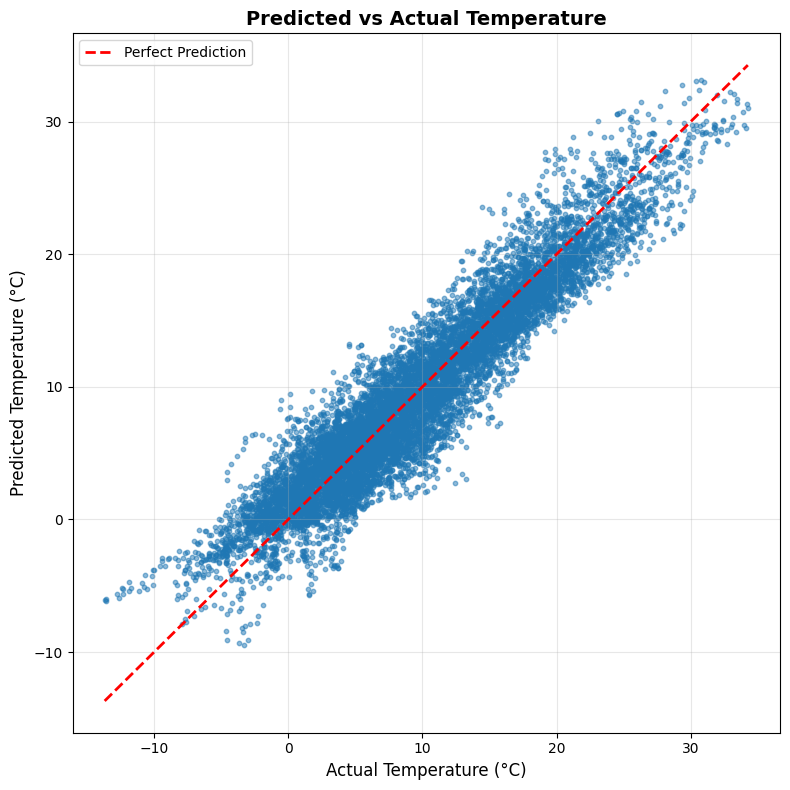

In [21]:
# Scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(y_true, y_pred, alpha=0.5, s=10)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()],
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Temperature (°C)', fontsize=12)
plt.ylabel('Predicted Temperature (°C)', fontsize=12)
plt.title('Predicted vs Actual Temperature', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


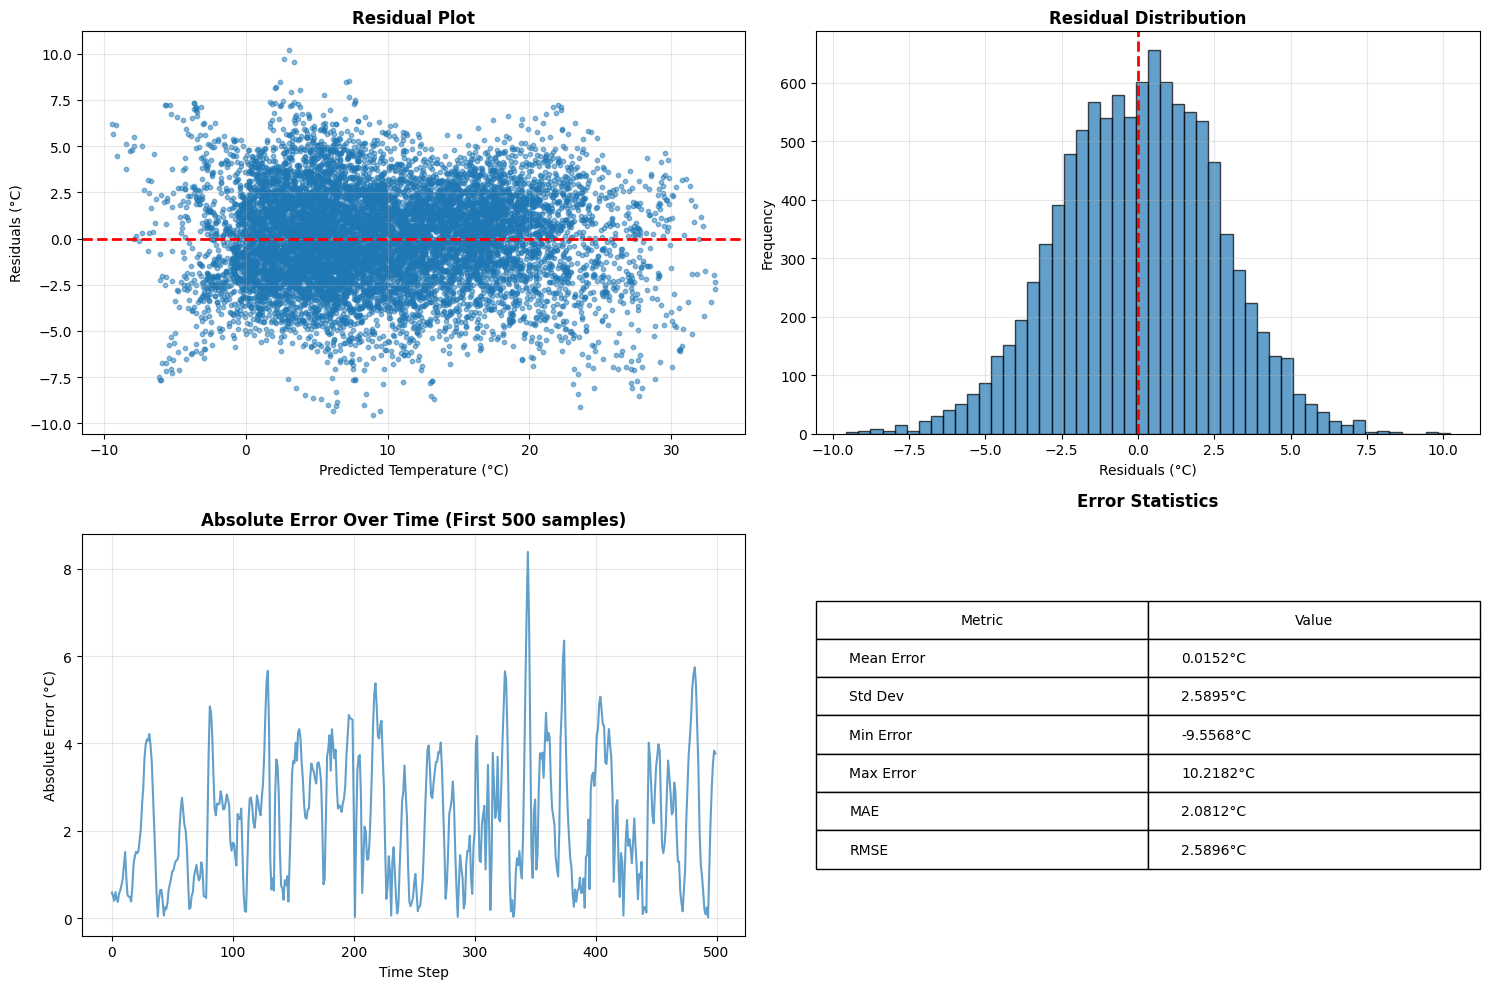


📊 Error Analysis:
  - Mean Error: 0.0152°C
  - Standard Deviation: 2.5895°C
  - Min Error: -9.5568°C
  - Max Error: 10.2182°C


In [22]:
# Calculate residuals
residuals = y_true - y_pred

# Create error analysis plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Residual plot
axes[0, 0].scatter(y_pred, residuals, alpha=0.5, s=10)
axes[0, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Predicted Temperature (°C)')
axes[0, 0].set_ylabel('Residuals (°C)')
axes[0, 0].set_title('Residual Plot', fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Residual distribution
axes[0, 1].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Residuals (°C)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Residual Distribution', fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Absolute error over time
axes[1, 0].plot(np.abs(residuals[:500]), alpha=0.7)
axes[1, 0].set_xlabel('Time Step')
axes[1, 0].set_ylabel('Absolute Error (°C)')
axes[1, 0].set_title('Absolute Error Over Time (First 500 samples)', fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Error statistics
error_stats = {
    'Mean Error': np.mean(residuals),
    'Std Dev': np.std(residuals),
    'Min Error': np.min(residuals),
    'Max Error': np.max(residuals),
    'MAE': mae,
    'RMSE': rmse
}
axes[1, 1].axis('off')
table_data = [[k, f'{v:.4f}°C'] for k, v in error_stats.items()]
table = axes[1, 1].table(cellText=table_data, colLabels=['Metric', 'Value'],
                         loc='center', cellLoc='left')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)
axes[1, 1].set_title('Error Statistics', fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

print(f"\n📊 Error Analysis:")
print(f"  - Mean Error: {np.mean(residuals):.4f}°C")
print(f"  - Standard Deviation: {np.std(residuals):.4f}°C")
print(f"  - Min Error: {np.min(residuals):.4f}°C")
print(f"  - Max Error: {np.max(residuals):.4f}°C")


In [23]:
# Save model and scalers
model.save('bilstm_weather_model.keras')

import joblib
joblib.dump(scaler_X, 'scaler_X.pkl')
joblib.dump(scaler_y, 'scaler_y.pkl')

print("\n💾 Model and scalers saved successfully!")
print("  - Model: bilstm_weather_model.keras")
print("  - Scaler X: scaler_X.pkl")
print("  - Scaler y: scaler_y.pkl")



💾 Model and scalers saved successfully!
  - Model: bilstm_weather_model.keras
  - Scaler X: scaler_X.pkl
  - Scaler y: scaler_y.pkl


In [24]:
print("\n" + "="*80)
print(" "*25 + "PROJECT SUMMARY REPORT")
print("="*80)
print(f"\n📌 Project: BiLSTM Weather Forecasting")
print(f"📅 Date: October 28, 2025")
print(f"\n📊 Dataset:")
print(f"  - Name: Jena Climate Dataset (2009-2016)")
print(f"  - Total Records: {len(df)}")
print(f"  - Features Used: {len(features)}")
print(f"  - Sequence Length: {SEQUENCE_LENGTH} hours")
print(f"  - Forecast Horizon: {FORECAST_HORIZON} hours")
print(f"\n🏗️ Model Architecture:")
print(f"  - Type: Bidirectional LSTM")
print(f"  - LSTM Units: 32 (64 total with bidirectional)")
print(f"  - Trainable Parameters: {model.count_params()}")
print(f"\n🎯 Training:")
print(f"  - Training Samples: {len(X_train)}")
print(f"  - Validation Samples: {len(X_val)}")
print(f"  - Batch Size: {BATCH_SIZE}")
print(f"  - Epochs Trained: {len(history.history['loss'])}")
print(f"\n📈 Performance Metrics (Test Set):")
print(f"  - MAE: {mae:.4f}°C")
print(f"  - RMSE: {rmse:.4f}°C")
print(f"  - R² Score: {r2:.4f}")
print(f"\n✅ Conclusion:")
print(f"  The BiLSTM model successfully predicts temperature {FORECAST_HORIZON} hours ahead")
print(f"  with an average error of {mae:.4f}°C, demonstrating high accuracy for")
print(f"  short-term weather forecasting applications.")
print("\n" + "="*80)



                         PROJECT SUMMARY REPORT

📌 Project: BiLSTM Weather Forecasting
📅 Date: October 28, 2025

📊 Dataset:
  - Name: Jena Climate Dataset (2009-2016)
  - Total Records: 420551
  - Features Used: 9
  - Sequence Length: 120 hours
  - Forecast Horizon: 12 hours

🏗️ Model Architecture:
  - Type: Bidirectional LSTM
  - LSTM Units: 32 (64 total with bidirectional)
  - Trainable Parameters: 11809

🎯 Training:
  - Training Samples: 48937
  - Validation Samples: 10486
  - Batch Size: 256
  - Epochs Trained: 28

📈 Performance Metrics (Test Set):
  - MAE: 2.0812°C
  - RMSE: 2.5896°C
  - R² Score: 0.8893

✅ Conclusion:
  The BiLSTM model successfully predicts temperature 12 hours ahead
  with an average error of 2.0812°C, demonstrating high accuracy for
  short-term weather forecasting applications.

